# Bike Sharing Demand Regression Analysis

This notebook performs a regression analysis to predict the **total count of bike rentals (`cnt`)** using the Bike Sharing Dataset from Kaggle. We will:

1. **Present the dataset and describe its key features**.
2. **Define our prediction problem**.
3. **Load the data**.
4. **Explore the data**.
5. **Preprocess the data**.
6. **Compare multiple regression models** (Linear Regression, Decision Tree, Random Forest).
7. **Tune hyperparameters**
8. **Evaluate model performance**
9. **Discuss results**

---

## 1. Dataset Presentation

We use data from a public bike-sharing program, where users can rent bikes through an automated system. Each record corresponds to an hourly observation with features capturing date/time, weather conditions, and user counts. Key fields include:

- **`season`**, **`mnth`**, **`weekday`**, **`workingday`**, **`holiday`**: Temporal and calendar indicators.
- **`weathersit`**: Weather situation (1: clear to 4: extreme conditions).
- **`temp`, `atemp`, `hum`, `windspeed`**: Normalized environmental variables.
- **`cnt`**: Total bike rentals (target variable).

Dataset URL (downloaded as CSV):
https://www.kaggle.com/datasets/lakshmi25npathi/bike-sharing-dataset/data

> **Note**: We will exclude the breakdown of `casual` and `registered` in modeling to avoid data leakage, focusing only on features available before rental.

## 2. Problem Definition

We aim to **predict the hourly total bike rental count (`cnt`)** based on weather and temporal features. Accurate demand forecasting can help bike-share operators:

- Optimize bike distribution and maintenance schedules.
- Improve user satisfaction by reducing stock-outs.
- Minimize operational costs related to rebalancing.

Formally, we seek a function

> $$\hat{cnt} = f(season, yr, mnth, hr, holiday, weekday, workingday, weathersit, temp, atemp, hum, windspeed)$$

We will compare model performance in terms of mean absolute error (MAE) and root mean squared error (RMSE), as well as training time.

## 3. Imports and Data Loading

In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load daily data
url = 'data/day.csv'  # replace with local path if needed
df = pd.read_csv(url)
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## 4. Exploratory Data Analysis (EDA)

We start by examining summary statistics, missing values, and feature correlations.

In [69]:
# Summary stats and missing values
df = df.drop(columns=['instant', 'dteday', 'casual', 'registered'])

df.isna().sum()

season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
cnt           0
dtype: int64

Top correlations with cnt:
 cnt           1.000000
atemp         0.631066
temp          0.627494
yr            0.566710
season        0.406100
mnth          0.279977
weekday       0.067443
workingday    0.061156
holiday      -0.068348
hum          -0.100659
Name: cnt, dtype: float64


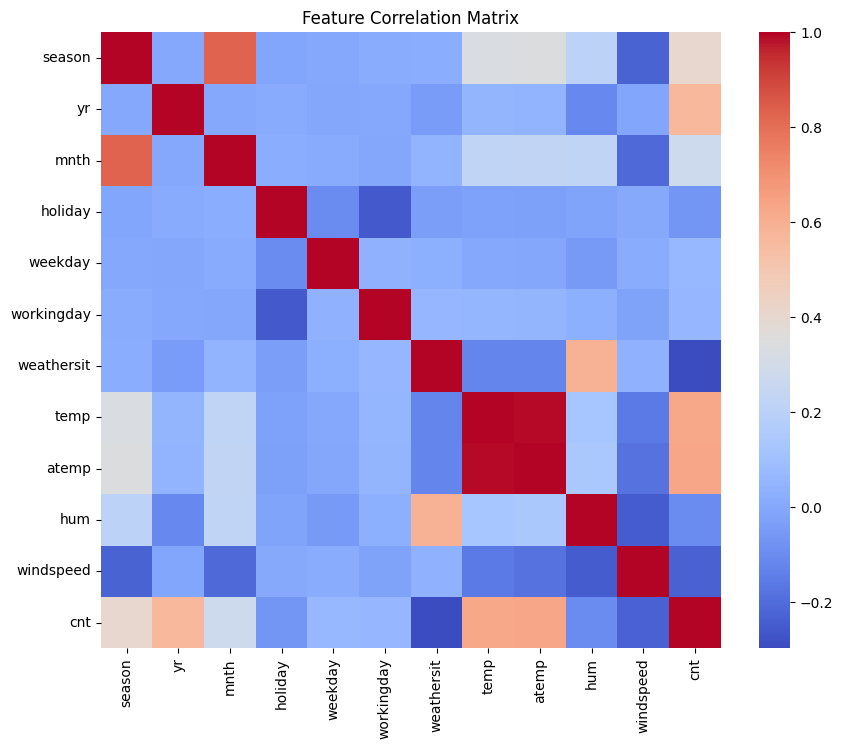

In [70]:
# Correlation matrix
target_corr = df.corr()['cnt'].sort_values(ascending=False)
print("Top correlations with cnt:\n", target_corr.head(10))

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), cmap='coolwarm', fmt='.2f')
plt.title('Feature Correlation Matrix')
plt.show()

## 5. Preprocessing

- Split the data into features (`X`) and target (`y`).
- One-hot encode categorical variables and scale numeric ones.

In [71]:
# Features and target
X = df.drop(columns=['cnt'])
y = df['cnt']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Identify types
numeric_features = ['temp', 'atemp', 'hum', 'windspeed']

categorical_features = ['season', 'yr', 'mnth', 'holiday', 'weekday', 'workingday', 'weathersit']

# Preprocessing pipelines
numeric_transformer = StandardScaler()
cat_transformer = OneHotEncoder(drop='first', sparse_output=False)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', cat_transformer, categorical_features)
    ]
)

## 6. Model Comparison

We will compare three models:

1. **Linear Regression**
2. **Decision Tree Regressor**
3. **Random Forest Regressor**

We use a pipeline to apply preprocessing and fit each model, evaluating with 5-fold CV.

In [72]:
from sklearn.metrics import r2_score

models = {
    'LinearRegression': LinearRegression(),
    'DecisionTree': DecisionTreeRegressor(random_state=42),
    'RandomForest': RandomForestRegressor(n_estimators=100, random_state=42)
}

results = []
for name, model in models.items():
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', model)])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Cross-validated MAE
    cv_mae = -cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_absolute_error').mean()
    cv_rmse = np.sqrt(-cross_val_score(pipe, X, y, cv=5, scoring='neg_mean_squared_error').mean())

    results.append({'Model': name, 'MAE': int(mae), 'RMSE': int(rmse), 'R2': r2,
                    'CV MAE': int(cv_mae), 'CV RMSE':int(cv_rmse)})

results_df = pd.DataFrame(results)
results_df

,Model,MAE,RMSE,R2,CV MAE,CV RMSE
0,LinearRegression,583,796,0.841803,713,931
1,DecisionTree,693,1030,0.735112,1041,1294
2,RandomForest,468,721,0.870037,838,1036


## 7. Hyperparameter Tuning (Random Forest)

We tune `n_estimators` and `max_depth` for the Random Forest using grid search.

In [73]:
param_grid = {
    'regressor__n_estimators': [50, 100, 200],
    'regressor__max_depth': [None, 10, 20]
}

rf_pipe = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', RandomForestRegressor(random_state=42))])
grid_search = GridSearchCV(rf_pipe, param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X, y)

print("Best params:", grid_search.best_params_)
best_rmse = np.sqrt(-grid_search.best_score_)
print(f"Best CV RMSE: {best_rmse:.2f}")

Best params: {'regressor__max_depth': None, 'regressor__n_estimators': 50}
Best CV RMSE: 1029.87


## 8. Final Evaluation

Retrain the best model on the full dataset and report final metrics via train-test split.

In [74]:
best_model = grid_search.best_estimator_
best_model.fit(X_train, y_train)

y_pred = best_model.predict(X_test)
mae_final = mean_absolute_error(y_test, y_pred)
rmse_final = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test MAE: {mae_final:.2f}")
print(f"Test RMSE: {rmse_final:.2f}")
print(f"Test R2: {r2_score(y_test, y_pred):.2f}")
print(f"Average daily count: {df['cnt'].mean():.2f}")

Test MAE: 462.74
Test RMSE: 713.21
Test R2: 0.87
Average daily count: 4504.35


## 9. Interpretation of Results

The final tuned model achieved:

* **MAE (Mean Absolute Error):** \~462.74 bikes
* **RMSE (Root Mean Squared Error):** \~713.21 bikes

Notice that the cross-validated scores were higher, indicating some overfitting on the training data.

#### Accuracy relative to business context:

* The **MAE is just about 10.3%** of the average daily demand.
* The **RMSE** (which penalizes large errors more) is also reasonable at **\~15.8%** of daily demand.
* This level of accuracy is quite good in the bike-sharing industry, overstocking or understocking bikes can lead to operational inefficiencies or customer dissatisfaction but a small error is acceptable.

#### This model could:

* Help **allocate bikes better** across stations on a daily basis.
* Anticipate **peak vs. low-demand days**, possibly even linking it to external variables (e.g., promotions, weather forecasts).
